# Calculate CAPE for a Norman sounding

In [27]:
import numpy as np
import pandas as pd
import h5py
from pprint import pformat
from importlib import reload
import a405thermo.thermlib
reload(a405thermo.thermlib)
from a405thermo.constants import constants as c
from a405thermo.thermlib import convertSkewToTemp, convertTempToSkew
import a405skewT.makeSkewII
reload(a405skewT.makeSkewII)
from a405skewT.makeSkewII import makeSkewWet

In [28]:
filename='OUN.h5';
print('reading file: %s\n' %filename)

attributes={}
with h5py.File(filename,'r') as f:
    keys=f.attrs.keys()
    for key in keys:
        try:
            attributes[key]=f.attrs[key]
        except IOError:
            print('empty key: ',key)
print('\nread in these attributes: \n\n',pformat(attributes))

separator= '\n' + '+'*30 + '\n'
sounding_dict={}
with pd.HDFStore(filename,'r') as store:
    times=store.keys()
    for the_time in times:
        sounding_dict[the_time]=store[the_time]
sounding=sounding_dict[times[40]]
# print('{0:}sounding times:{1:}{0:} '.format(separator,times))
# print('{0:}columns: {1:}{0:} '.format(separator,pformat(sounding.columns)))
title_string=attributes['header']
index=title_string.find(' Observations at')
location=title_string[:index]
title='{} at {}'.format(location,times[40])
print('title: :',title)
units=attributes['units'].split(';')
units_dict={}
for count,var in enumerate(sounding.columns):
    units_dict[var]=units[count]

reading file: OUN.h5

empty key:  TITLE
empty key:  CLASS
empty key:  VERSION
empty key:  PYTABLES_FORMAT_VERSION

read in these attributes: 

 {'elevation': 3.0,
 'header': '72357 OUN Norman Observations at 00Z 01 May 2013',
 'history': 'written by test_requests.py',
 'latitude': 35.18,
 'longitude': -97.439999999999998,
 'query': 'http://weather.uwyo.edu/cgi-bin/sounding?region=naconf&TYPE=TEXT%3ALIST&YEAR=2013&MONTH=5&FROM=0100&TO=3112&STNM=72357',
 'site_id': '72357',
 'timestamp': '2016-01-19 23:16:57 UTC',
 'units': 'hPa;m;C;C;%;g/kg;deg;knot;K;K;K'}
title: : 72357 OUN Norman at /Y2013_May_20_18Z


In [29]:
skew=30.
triplets=zip(sounding['temp'],sounding['dwpt'],sounding['pres'])
xcoord_T=[]
xcoord_Td=[]
for a_temp,a_dew,a_pres in triplets:
    xcoord_T.append(convertTempToSkew(a_temp,a_pres,skew))
    xcoord_Td.append(convertTempToSkew(a_dew,a_pres,skew))

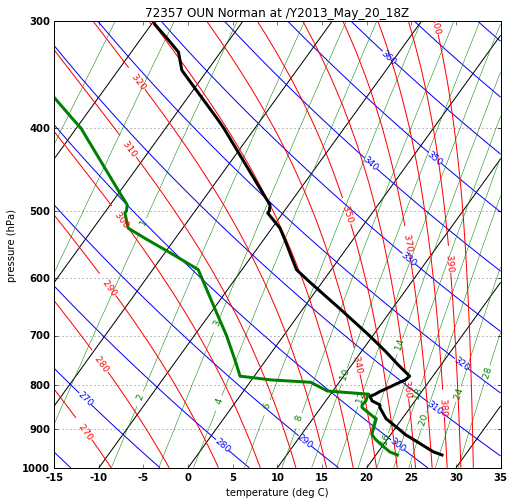

In [30]:
%matplotlib inline
skew=30
plt.close('all')
fig,ax =plt.subplots(1,1,figsize=(8,8))
corners=[-15,35]
ax,skew = makeSkewWet(ax,corners=corners,skew=skew)
ax.plot(xcoord_T,sounding['pres'],color='k',label='temp')
ax.plot(xcoord_Td,sounding['pres'],color='g',label='dew')
[line.set(linewidth=3) for line in ax.lines[-2:]]
out=ax.set(title=title)

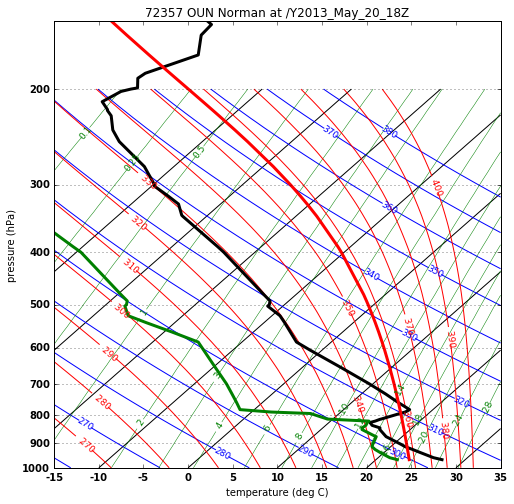

In [31]:
from a405thermo.thermlib import find_Tmoist,find_thetaep,find_rsat,find_Tv
#
# find thetae of the surface air
#
sfc_press,sfc_temp,sfc_td =[sounding[key][0] for key in ['pres','temp','dwpt']]
sfc_press,sfc_temp,sfc_td = sfc_press*100.,sfc_temp+c.Tc,sfc_td+c.Tc
sfc_rvap = find_rsat(sfc_temp,sfc_press)
sfc_thetae=find_thetaep(sfc_td,sfc_temp,sfc_press)
press=sounding['pres'].values*100.
#
# find the index for 200 hPa pressure -- searchsorted requires
# the pressure array to be increasing, so flip it for the search,
# then flip the index.  Above 200 hPa thetae goes bananas, so
# so trim so we only have 
#
toplim=len(press) - np.searchsorted(press[::-1],150.e2)
press=press[:toplim]
#
# find temps along that adiabat
#
adia_temps= np.array([find_Tmoist(sfc_thetae,the_press) for the_press in press])
adia_rvaps = find_rsat(adia_temps,press)
adia_rls = sfc_rvap - adia_rvaps
env_temps = (sounding['temp'].values + c.Tc)[:toplim]
env_Td = (sounding['dwpt'].values + c.Tc)[:toplim]
height = sounding['hght'].values[:toplim]
pairs = zip(env_Td,press)
env_rvaps= np.array([find_rsat(td,the_press) for td,the_press in pairs])
env_Tv = find_Tv(env_temps,env_rvaps)
adia_Tv = find_Tv(adia_temps,adia_rvaps,adia_rls)
xcoord_thetae=[]
press_hPa = press*1.e-2
for a_temp,a_press in zip(adia_temps - c.Tc,press_hPa):
    out=convertTempToSkew(a_temp,a_press,skew)
    xcoord_thetae.append(out)
ax.plot(xcoord_thetae,press_hPa,color='r',label='rsat',linewidth=3.)
ax.set(ylim=[1000.,150.])
display(fig)


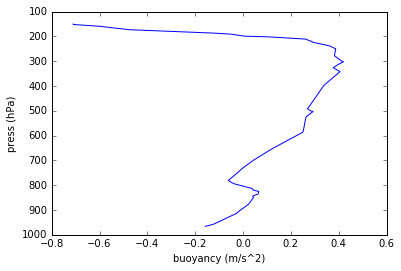

In [32]:
def find_buoy(adia_Tv,env_Tv):
  buoy=c.g0*(adia_Tv - env_Tv)/env_Tv
  return buoy

#
# moved find_buoy to library
#
from a405thermo.thermlib import find_buoy
    
fig,ax =plt.subplots(1,1)
buoy=find_buoy(adia_Tv,env_Tv)
ax.plot(buoy,press*1.e-2)
ax.invert_yaxis()
out=ax.set(ylabel='press (hPa)',xlabel='buoyancy (m/s^2)')

### Find the bottom and top buoyancy zero crossings

In [33]:
#np.searchsorted finds the first crossing
zerobot=np.searchsorted(buoy,0)
#flip the array and search backwards for top crossing
zerotop=len(buoy) - np.searchsorted(buoy[::-1],0)
print('pressure levels for crossing: {} hPa {} hPa'\
      .format(press[zerobot]*0.01,press[zerotop]*0.01))

pressure levels for crossing: 876.0 hPa 191.0 hPa


### find the cape

In [34]:
clipped_buoy = buoy[zerobot:zerotop]
clipped_height = height[zerobot:zerotop]
#average the levels to get layer buoyancy
layer_buoy = (clipped_buoy[:-1] + clipped_buoy[1:])/2.
cape = np.sum(layer_buoy*np.diff(clipped_height))
print('cape is {:6.2f} J/kg'.format(cape))

cape is 2718.57 J/kg


In [35]:
def find_vv(CAPE):
    '''finds the max vertical velocity for an updraft
    input: CAPE (J/kg, float)
    output: w_max (m/s, float)'''
    
    w_max = np.sqrt(2*CAPE)
    return w_max

vv_max = find_vv(cape)

print('Max updraft velocity is {:6.3f} m/s'.format(vv_max))

Max updraft velocity is 73.737 m/s


In [36]:
print('Level of neutral buoyancy is {:6.1f} hPa'.format(press[zerotop]*0.01))

Level of neutral buoyancy is  191.0 hPa


In [38]:
negbuoy = buoy[zerotop:-1]
negheight = height[zerotop:-1]
neglayer_buoy = (negbuoy[:-1] + negbuoy[1:])/2.
negcape = np.sum(neglayer_buoy*np.diff(negheight))

def maxcloudtop(pressure,cape):
    '''Finds the maximum theoretical cloud top height
    inputs: pressure at LNB (hPa), cape (J/kg)
    outputs: pressure at max cloud top height (hPa)'''
    return

print('''Was not able to get the maximum cloud top height, 
       theta goes haywire before you can find -{:6.2f} J/kg'''.format(cape))

Was not able to get the maximum cloud top height, 
       theta goes haywire before you can find -2718.57 J/kg
